# Importing libraries

In [13]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from termcolor import colored
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
import shap

# Preliminary analysis

In [14]:
# Load the dataset
dataset = pd.read_csv('heart.csv')
print(dataset.shape)

(918, 12)


The dataset consists of 12 columns (features), the last of which contains the labels. It is therefore composed of 918 rows.

In [15]:
dataset.head(5)

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


Here I print the first 5 rows to check how the dataset is structured and the different values in each column.

## NaN check

In [16]:
nan_in_df = dataset.isnull().sum().any()
print(nan_in_df)

False


Before doing any kind of manipulation, check if there are any nans in the dataset. Here we can see that there are none.

## Duplicate check

In [17]:
duplicateRows = dataset[dataset.duplicated()]

#view duplicate rows
duplicateRows

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease


I do another check, this time looking for duplicates. Again, there are no items to remove.

# Exploratory analysis

Before proceeding with any form of manipulation, I am conducting an exploratory analysis of the data. Using the dataset description provided on Kaggle, I am examining how the variables are related.

## Sex distribution

In [18]:
gender_heart_disease_counts = dataset.groupby('HeartDisease')['Sex'].value_counts().reset_index(name='Count')
gender_heart_disease_counts

,HeartDisease,Sex,Count
0,0,M,267
1,0,F,143
2,1,M,458
3,1,F,50


In [19]:
fig = px.pie(gender_heart_disease_counts,
             values='Count',
             names='Sex',
             color='Sex',
             color_discrete_sequence=['#106C93', 'pink'],
             title='Relationship between Sex and HeartDisease',
             labels={'Sex': 'Gender'})

fig.update_traces(textinfo='percent+label', pull=[0.1, 0])

fig.show()

The first thing I checked is the overall distribution of  hearth diseases according to the genders in the dataset. As we can see only 25% of the dataset is composed by women.

## Relationship between Sex and HeartDisease

In [20]:
dataset.groupby('HeartDisease')['Sex'].value_counts()

HeartDisease  Sex
0             M      267
              F      143
1             M      458
              F       50
Name: Sex, dtype: int64

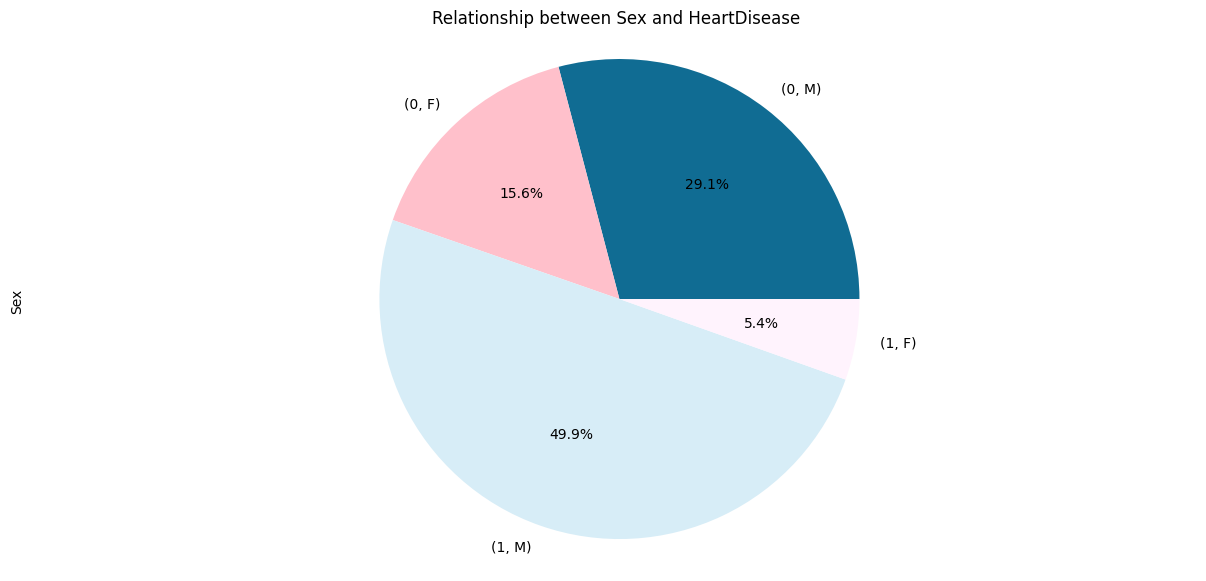

In [21]:
dataset.groupby('HeartDisease')['Sex'].value_counts().plot.pie(autopct ='%1.1f%%',colors=['#106C93','pink','#D7EDF7','#FFF3FD'],figsize=(15,7))
plt.title('Relationship between Sex and HeartDisease')
plt.axis('equal')
plt.show()

From this pie chart we can see that in the dataset there are many more men, with an incidence of over 50% of the total dataset. Men are always the ones most affected by a hearth disease.

## Distribution of patients over age

In [22]:
patients_hd = dataset[dataset['HeartDisease']==1]
patient_ok = dataset[dataset['HeartDisease']==0]

fig=go.Figure()

fig.add_trace(go.Violin(x=patients_hd['Age'],line_color='red',y0=0,name='Age of patients with Hearth Disease'))

fig.add_trace(go.Violin(x=patient_ok['Age'],line_color='#2C3E50',y0=0,name='Age of patients without Hearth Disease'))

fig.update_traces(orientation='h',side='positive',meanline_visible=True)

fig.update_layout(title='Distribution of patients over age',
                 titlefont={'size':30},
                 xaxis_zeroline=False)

fig.update_xaxes(showgrid=False,title='Age')
fig.update_traces(opacity=0.7)

fig.show()

Here I plot the age distributions, where we can notice how the age could be an indicator for a hearth disease.

## Effect of ChestPainType on HeartDisease

In [23]:
heart_disease_group = dataset.groupby('HeartDisease')
heart_disease_1_group = heart_disease_group.get_group(1)
heart_disease_1_group['ChestPainType'].value_counts()

ASY    392
NAP     72
ATA     24
TA      20
Name: ChestPainType, dtype: int64

In [24]:
fig = px.histogram(dataset, x="ChestPainType", color="HeartDisease",
                   histnorm='percent',barmode="group",
                   )


fig.update_layout(title='Effect of ChestPainType on heartdisease',
                 title_font={'size':20},
                 showlegend=True)


fig.show(showgrid=False)

From the following histogram we can instead see how the greatest number of patients affected by heart disease is of the ASY chest pain type, while in the others we have a fairly balanced situation.

## Effect of RestingECG on heartdisease

In [25]:
heart_disease_group = dataset.groupby('HeartDisease')
heart_disease_1_group = heart_disease_group.get_group(1)
heart_disease_1_group['RestingECG'].value_counts()

Normal    285
ST        117
LVH       106
Name: RestingECG, dtype: int64

In [26]:
fig = px.pie(dataset, values='HeartDisease', names='RestingECG',
             title="Effect of RestingECG on heartdisease",
             height=700, width=800)

fig.show()

In the restingECG we can instead notice how the most affected type is the normal type.

## Effect of RestingBP on HeartDisease

In [27]:
patients_hd = dataset[dataset['HeartDisease']==1]
patient_ok = dataset[dataset['HeartDisease']==0]

fig = ff.create_distplot([patients_hd['RestingBP'], patient_ok['RestingBP']],
                        ['Patients with Hearth Disease','Patients without Hearth Disease'],
                         show_hist=False,
                         show_rug=False,
                         )

fig.update_layout(title='Effect of RestingBP on HeartDisease',
                 title_font={'size':30},
                 showlegend=True)

fig.update_xaxes(showgrid=False,title='RestingBP')
fig.update_yaxes(showgrid=False)

fig.show()

From this distribution, however, we can see how the heart rate at rest is much lower in patients suffering from heart disease.

## Effect of Cholesterol on HeartDisease

In [28]:
fig=px.strip(dataset,x='HeartDisease',y='Cholesterol',color='HeartDisease')
fig.update_layout(title='Effect of Cholesterol on HeartDisease',
                  titlefont={'size': 24,'family': 'Serif'},
                  showlegend=True)
fig.update_yaxes(showgrid=False)
fig.show()

In the case of cholesterol, the difference is less visible, although it is possible to note that it is much more volatile in the case of patients with heart disease.

## Effect of MaxHR on HeartDisease

In [29]:
patients_hd = dataset[dataset['HeartDisease']==1]
patient_ok = dataset[dataset['HeartDisease']==0]

fig = ff.create_distplot([patients_hd['MaxHR'], patient_ok['MaxHR']],
                        ['Patients with Hearth Disease','Patients without Hearth Disease'],
                         show_hist=True,
                         show_rug=False,
                         )
fig.update_layout(title='Effect of MaxHR on heartdisease',
                 title_font={'size':30},
                 showlegend=True)
fig.update_xaxes(showgrid=False,title='MaxHR')
fig.update_yaxes(showgrid=False)
fig.show()

The Difference in MaxHR is similar to that of resting BP, where we may notice a large difference in the distributions.

## Effect of Oldpeak on HeartDisease

In [30]:
fig=px.violin(dataset,color='HeartDisease',
               x='HeartDisease',y='Oldpeak',
               title='Effect of Oldpeak on HeartDisease',
              violinmode='overlay',box=True,points='all')

fig.update_layout(title_font={'size':30})
fig.show()

In the oldpeaks the difference is more notable, where we can highlight changes in value intensity and outliers.

# Data preprocessing

In [31]:
dataset.dtypes

Age                 int64
Sex                object
ChestPainType      object
RestingBP           int64
Cholesterol         int64
FastingBS           int64
RestingECG         object
MaxHR               int64
ExerciseAngina     object
Oldpeak           float64
ST_Slope           object
HeartDisease        int64
dtype: object

First of all, I check the types of the columns, to understand which ones are numeric and which are categorical.

## Check column types

In [32]:
print(dataset['Sex'].unique())
print(dataset['ChestPainType'].unique())
print(dataset['RestingECG'].unique())
print(dataset['ExerciseAngina'].unique())
print(dataset['ST_Slope'].unique())

['M' 'F']
['ATA' 'NAP' 'ASY' 'TA']
['Normal' 'ST' 'LVH']
['N' 'Y']
['Up' 'Flat' 'Down']


To be sure, I also check the possible outcomes of the variables to make sure they are consistent with the dataset description provided.

## Normalize columns

In [33]:
dataset['Sex'] = dataset['Sex'].map({'M': 0, 'F': 1})
dataset['ChestPainType'] = dataset['ChestPainType'].map({'ATA': 0, 'NAP': 1, 'ASY': 2, 'TA': 3})
dataset['RestingECG'] = dataset['RestingECG'].map({'Normal': 0, 'ST': 1, 'LVH': 2})
dataset['ExerciseAngina'] = dataset['ExerciseAngina'].map({'N': 0, 'Y': 1})
dataset['ST_Slope'] = dataset['ST_Slope'].map({'Up': 0, 'Flat': 1, 'Down': 2})

Since I am now certain that these are the only values, I perform a simple mapping to distinguish the values. I could have used other techniques such as one hot encoding, but I did not consider it necessary.

In [34]:
numerical_columns = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
scaler = StandardScaler()
dataset[numerical_columns] = scaler.fit_transform(dataset[numerical_columns])

I then proceed to normalize the numeric columns.

## Correlation matrix

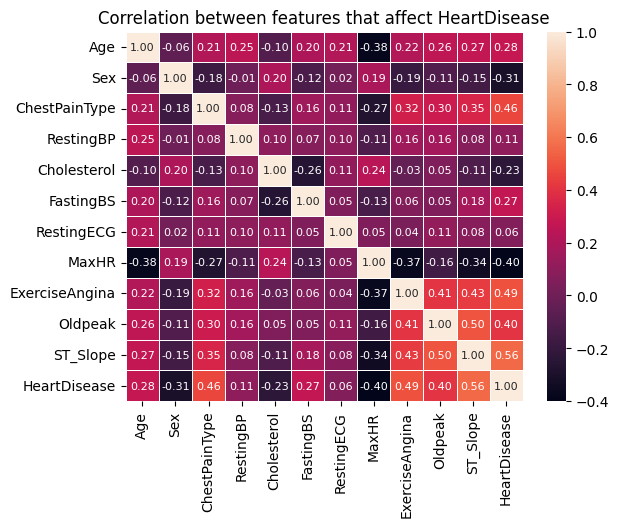

In [35]:
correlation=dataset.corr()
sns.heatmap(correlation,annot=True,fmt=".2F",annot_kws={"size":8},linewidths=0.5)
plt.title('Correlation between features that affect HeartDisease')
plt.show()

The correlation matrix gives me extra information about the variables that I am most closely related to, as we can see in the case of ST_Slope and Oldpeak.

In [36]:
dataset.head(5)

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,-1.433140,0,0,0.410909,0.825070,0,0,1.382928,0,-0.832432,0,0
1,-0.478484,1,1,1.491752,-0.171961,0,0,0.754157,0,0.105664,1,1
2,-1.751359,0,0,-0.129513,0.770188,0,1,-1.525138,0,-0.832432,0,0
3,-0.584556,1,2,0.302825,0.139040,0,0,-1.132156,1,0.574711,1,1
4,0.051881,0,1,0.951331,-0.034755,0,0,-0.581981,0,-0.832432,0,0


After applying the transformation, I immediately check the new structure of the values in each column

## Check values distributions

array([[<AxesSubplot:title={'center':'Age'}>,
        <AxesSubplot:title={'center':'Sex'}>,
        <AxesSubplot:title={'center':'ChestPainType'}>],
       [<AxesSubplot:title={'center':'RestingBP'}>,
        <AxesSubplot:title={'center':'Cholesterol'}>,
        <AxesSubplot:title={'center':'FastingBS'}>],
       [<AxesSubplot:title={'center':'RestingECG'}>,
        <AxesSubplot:title={'center':'MaxHR'}>,
        <AxesSubplot:title={'center':'ExerciseAngina'}>],
       [<AxesSubplot:title={'center':'Oldpeak'}>,
        <AxesSubplot:title={'center':'ST_Slope'}>,
        <AxesSubplot:title={'center':'HeartDisease'}>]], dtype=object)

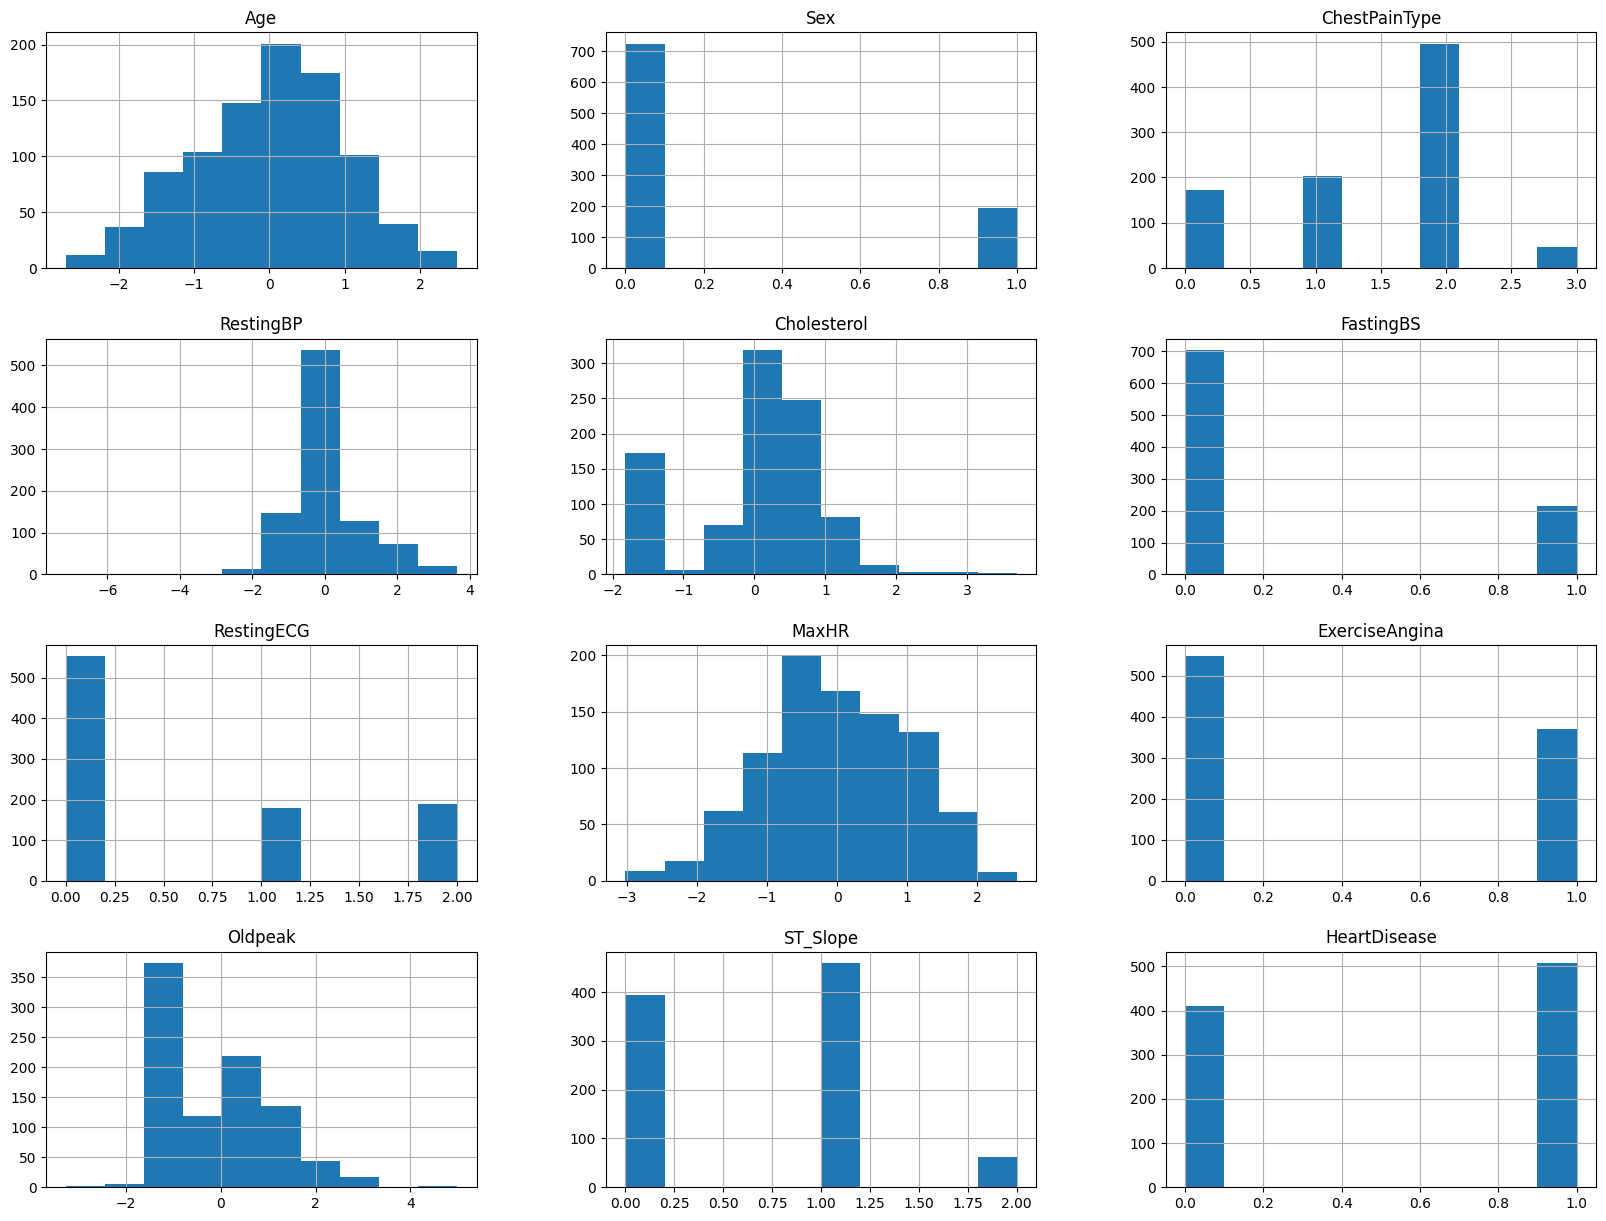

In [37]:
dataset.hist(figsize=(20,15))

Here I display the general plot with all the columns to have a look at the distributions

array([[<AxesSubplot:title={'center':'Age'}>,
        <AxesSubplot:title={'center':'Cholesterol'}>],
       [<AxesSubplot:title={'center':'RestingBP'}>,
        <AxesSubplot:title={'center':'MaxHR'}>],
       [<AxesSubplot:title={'center':'Oldpeak'}>, <AxesSubplot:>]],
      dtype=object)

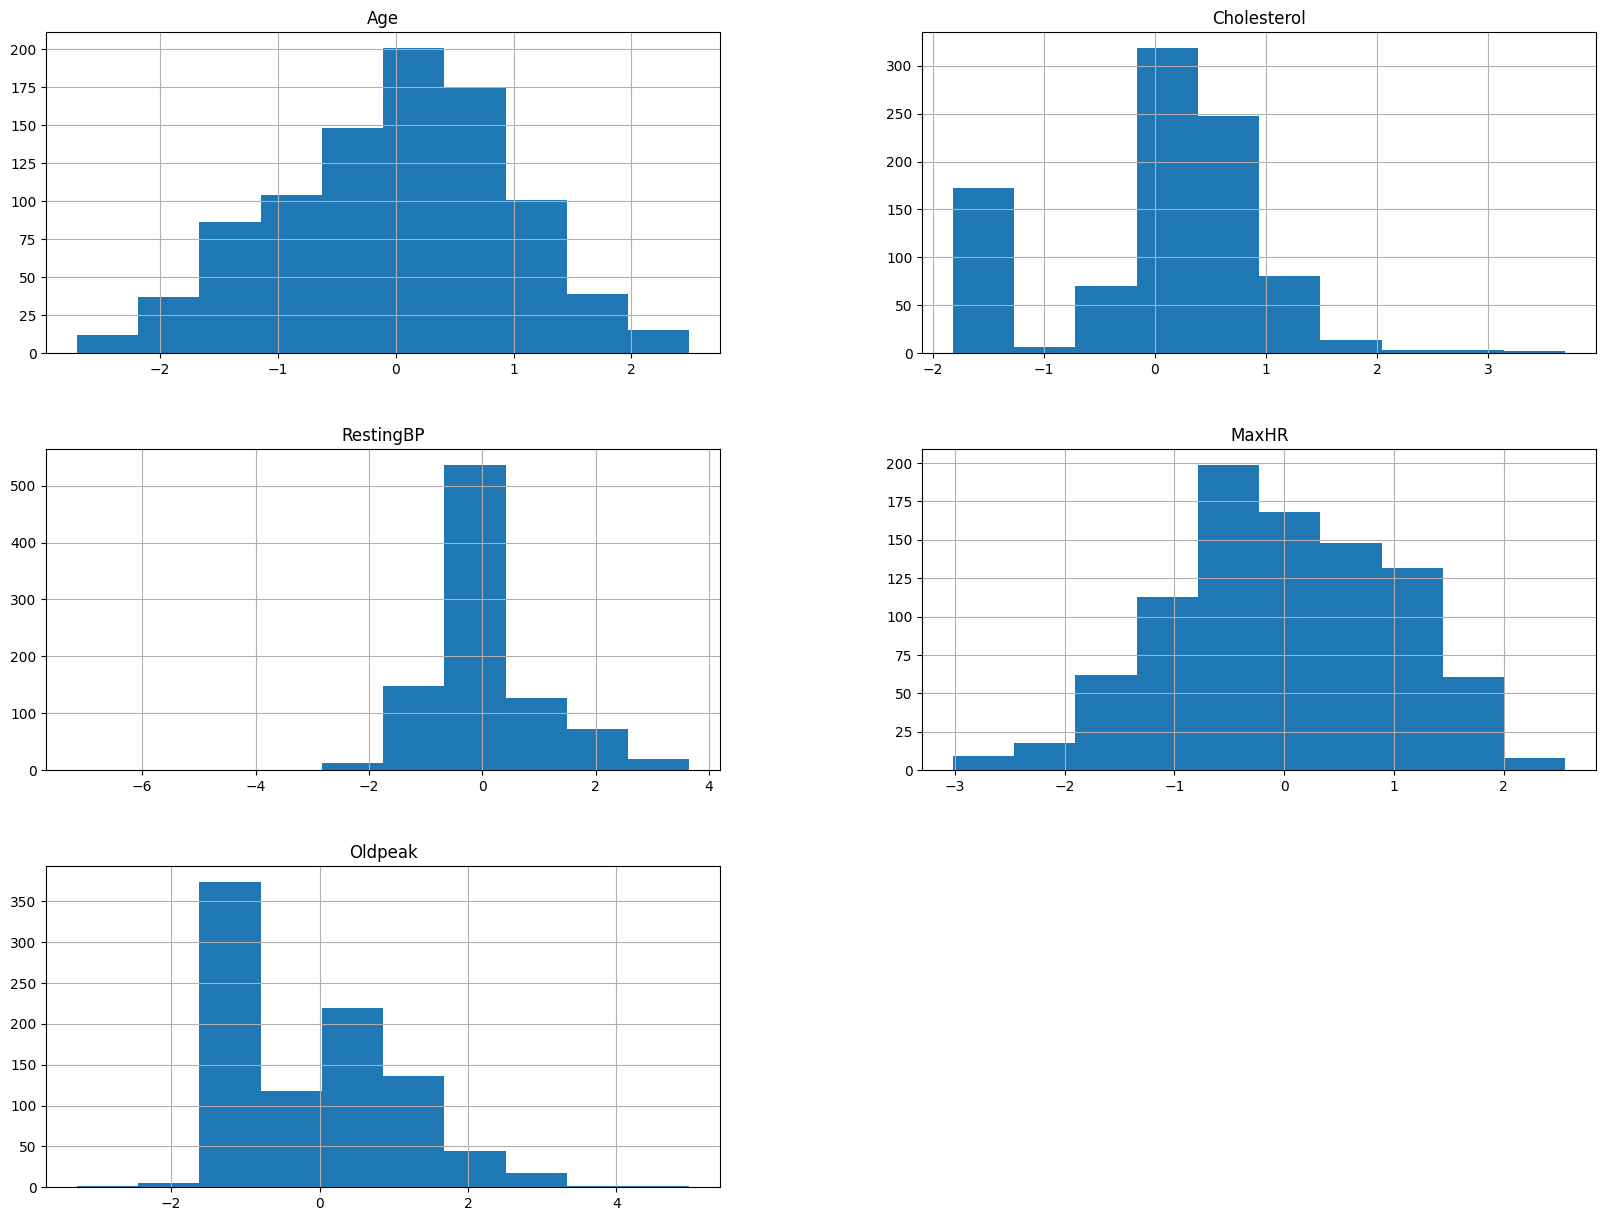

In [38]:
dataset[['Age', 'Cholesterol', 'RestingBP', 'MaxHR', 'Oldpeak']].hist(figsize=(20,15))

Here I focus on the numerical columns, noting that there are cases of oulier that could later lead to a classification error

## Outliers processing

In [39]:
# Select only numeric columns for z-score calculation
numeric_columns = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
means = dataset[numeric_columns].mean()
std_devs = dataset[numeric_columns].std()
z_scores = (dataset[numeric_columns] - means) / std_devs
z_scores_rounded = z_scores.round(2)
dataset = dataset.assign(**{col + '_zscore': z_scores_rounded[col] for col in numeric_columns})

In [40]:
# Statistical summary of the dataset
dataset.describe()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease,Age_zscore,RestingBP_zscore,Cholesterol_zscore,MaxHR_zscore,Oldpeak_zscore
count,9.180000e+02,918.000000,918.000000,9.180000e+02,918.000000,918.000000,918.000000,9.180000e+02,918.000000,9.180000e+02,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,-1.083616e-16,0.210240,1.452070,1.954380e-16,0.000000,0.233115,0.603486,4.953675e-16,0.404139,1.238419e-16,0.638344,0.553377,0.000153,-0.000545,-0.000566,0.000174,0.000784
std,1.000545e+00,0.407701,0.851832,1.000545e+00,1.000545,0.423046,0.805968,1.000545e+00,0.490992,1.000545e+00,0.607056,0.497414,0.999842,0.999763,1.000877,0.999951,0.998986
min,-2.706015e+00,0.000000,0.000000,-7.154995e+00,-1.818435,0.000000,0.000000,-3.018469e+00,0.000000,-3.271482e+00,0.000000,0.000000,-2.700000,-7.150000,-1.820000,-3.020000,-3.270000
25%,-6.906294e-01,0.000000,1.000000,-6.699346e-01,-0.233704,0.000000,0.000000,-6.605778e-01,0.000000,-8.324324e-01,0.000000,0.000000,-0.690000,-0.670000,-0.237500,-0.660000,-0.830000
50%,5.188098e-02,0.000000,2.000000,-1.295128e-01,0.221363,0.000000,0.000000,4.678968e-02,0.000000,-2.695748e-01,1.000000,1.000000,0.050000,-0.130000,0.220000,0.050000,-0.270000
75%,6.883185e-01,0.000000,2.000000,4.109089e-01,0.623835,0.000000,1.000000,7.541571e-01,1.000000,5.747115e-01,1.000000,1.000000,0.690000,0.410000,0.620000,0.750000,0.570000
max,2.491558e+00,1.000000,3.000000,3.653439e+00,3.697252,1.000000,2.000000,2.561874e+00,1.000000,4.983762e+00,2.000000,1.000000,2.490000,3.650000,3.700000,2.560000,4.980000


So I decide to calculate the zscores to see how much the values of each column deviate from the mean, so that I can apply a threshold

In [41]:
# Filter outliers based on the threshold of ±2.4
threshold = 2.4
outlier_mask = abs(z_scores) > threshold
outlier_rows = outlier_mask.any(axis=1)
dataset = dataset[~outlier_rows]

original_columns = [col for col in dataset.columns if not col.endswith('_zscore')]
dataset = dataset[original_columns]

In [42]:
dataset.describe()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
count,849.000000,849.000000,849.000000,849.000000,849.000000,849.000000,849.000000,849.000000,849.000000,849.000000,849.000000,849.000000
mean,-0.014212,0.210836,1.441696,-0.069424,-0.020447,0.232038,0.594817,0.020221,0.396938,-0.062509,0.612485,0.538280
std,0.979268,0.408143,0.856003,0.862865,0.954329,0.422382,0.804335,0.967316,0.489551,0.880162,0.592313,0.498826
min,-2.387796,0.000000,0.000000,-2.183115,-1.818435,0.000000,0.000000,-2.350400,0.000000,-2.239576,0.000000,0.000000
25%,-0.690629,0.000000,1.000000,-0.669935,-0.217696,0.000000,0.000000,-0.660578,0.000000,-0.832432,0.000000,0.000000
50%,0.051881,0.000000,2.000000,-0.129513,0.203069,0.000000,0.000000,0.046790,0.000000,-0.363384,1.000000,1.000000
75%,0.688318,0.000000,2.000000,0.410909,0.596393,0.000000,1.000000,0.754157,1.000000,0.574711,1.000000,1.000000
max,2.385485,1.000000,3.000000,2.248343,1.995896,1.000000,2.000000,2.247488,1.000000,2.357094,2.000000,1.000000


I decided to filter using a threshold of 2.4, in order to exclude the most serious outliers and at the same time keep a sufficient number of samples

In [43]:
dataset.head(15)

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,-1.433140,0,0,0.410909,0.825070,0,0,1.382928,0,-0.832432,0,0
1,-0.478484,1,1,1.491752,-0.171961,0,0,0.754157,0,0.105664,1,1
2,-1.751359,0,0,-0.129513,0.770188,0,1,-1.525138,0,-0.832432,0,0
3,-0.584556,1,2,0.302825,0.139040,0,0,-1.132156,1,0.574711,1,1
4,0.051881,0,1,0.951331,-0.034755,0,0,-0.581981,0,-0.832432,0,0
5,-1.539213,0,1,-0.669935,1.282424,0,0,1.304332,0,-0.832432,0,0
6,-0.902775,1,0,-0.129513,0.349422,0,0,1.304332,0,-0.832432,0,0
7,0.051881,0,0,-1.210356,0.084157,0,0,0.203982,0,-0.832432,0,0
8,-1.751359,0,2,0.410909,0.075010,0,0,-0.267596,1,0.574711,1,1
9,-0.584556,1,0,-0.669935,0.779335,0,0,-0.660578,0,-0.832432,0,0


In [44]:
# Count of each class in the target column
print(dataset['HeartDisease'].value_counts())

1    457
0    392
Name: HeartDisease, dtype: int64


Finally, before proceeding with the creation of the model, I check if the dataset is unbalanced

# Model Training

## Split dataset

In [45]:
X = dataset.drop(columns=["HeartDisease"]).values
y = dataset["HeartDisease"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=True, random_state=42)

Here I split the dataset. I maintain an 60:20:20 ratio, using random state to reproduce the experiments.

## Logistic Regression

In [46]:
C_values = np.logspace(-4, 4, 40)

validation_accuracies = []

coefs = []

for C in C_values:
    model = LogisticRegression(C=C, solver='liblinear', penalty = "l2", max_iter=1000)
    model.fit(X_train, y_train)

    val_accuracy = model.score(X_val, y_val)
    validation_accuracies.append(val_accuracy)

    coefs.append(model.coef_[0])

Here I perform an analysis of the logistic regression model with L2 regularization to evaluate the accuracy of the model on a validation data set and obtain the coefficients of the model for different values of regularization C.

# Results analysis

## Validation Accuracy vs. Regularization Strength

In [47]:
validation_accuracies = np.array(validation_accuracies)
coefs = np.array(coefs)

best_index = np.argmax(validation_accuracies)
optimal_C = C_values[best_index]

fig = go.Figure()

fig.add_trace(go.Scatter(x=C_values, y=validation_accuracies, mode='markers+lines', marker=dict(size=8),
                         line=dict(width=2)))
fig.update_layout(
    xaxis_type="log",
    xaxis_title="Regularization Strength (C)",
    yaxis_title="Validation Accuracy",
    title="Validation Accuracy vs. Regularization Strength",
    width=800,
    height=600,
    showlegend=False,
    template='plotly_white',
    xaxis=dict(showline=True, showgrid=True, showticklabels=True),
    yaxis=dict(showline=True, showgrid=True, showticklabels=True),
    margin=dict(l=50, r=50, t=50, b=50)
)

fig.add_trace(go.Scatter(x=[optimal_C], y=[validation_accuracies[best_index]], mode='markers',
                         marker=dict(color='red', size=12)))

fig.show()

The generated graph shows the relationship between the C value and the validation accuracy obtained from the logistic regression model for each value of C tested. In this graph, on the y axis we have the validation accuracy and on the x axis we have the different values of C.

## Regularization Path for Logistic Regression

In [48]:
# Plot the regularization path
C_values = np.array(C_values)
class_names = ["Age", "Sex", "ChestPainType", "RestingBP", "Cholesterol", "FastingBS", "RestingECG", "MaxHR", "ExerciseAngina", "Oldpeak", "ST_Slope"]

fig = go.Figure()

for i in range(coefs.shape[1]):
    class_name = class_names[i]
    fig.add_trace(go.Scatter(x=C_values, y=coefs[:, i], mode='lines', name=class_name, line=dict(width=2)))

fig.update_layout(
    xaxis_type="log",
    xaxis_title="Regularization Strength (C)",
    yaxis_title="Coefficient Value",
    title="Regularization Path for Logistic Regression Coefficients",
    width=800,
    height=600,
    showlegend=True,
    template='plotly_white',
    xaxis=dict(showline=True, showgrid=True, showticklabels=True),
    yaxis=dict(showline=True, showgrid=True, showticklabels=True),
    margin=dict(l=50, r=50, t=50, b=50)
)

fig.show()

Here I generate a graph representing the regularization path of the coefficients of the logistic regression model. Specifically, the graph shows how the coefficients of the model change as different levels of regularization C change.

## Optimal value of L2 regularization

In [49]:
final_model = LogisticRegression(C=optimal_C, solver='liblinear', penalty = "l2", max_iter=1000)
final_model.fit(np.vstack((X_train, X_val)), np.hstack((y_train, y_val)))

y_pred = final_model.predict(X_test)
f1_score_test = f1_score(y_test, y_pred)

print(f"Optimal value of L2 regularization (C): {optimal_C}")
print(f"F1 Score on the test set: {f1_score_test:.2f}")

Optimal value of L2 regularization (C): 1.2663801734674023
F1 Score on the test set: 0.86


## Confusion matrix

In [50]:
y_pred = final_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

text_values = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)

fig = ff.create_annotated_heatmap(cm, x=['No Heart Disease', 'Heart Disease'],
                                  y=['No Heart Disease', 'Heart Disease'],
                                  colorscale='Viridis')

fig.update_layout(
    title='Confusion Matrix',
    yaxis_title='Predicted label',
    xaxis_title='True label',
    yaxis=dict(showline=True, showgrid=False, showticklabels=True),
    xaxis=dict(showline=True, showgrid=False, showticklabels=True),
    width=600,
    height=500
)

fig.show()

In the confusion matrix we can see low misclassification, compared with more than 80 percent of correctly classified examples.

## ROC Curve

In [51]:
y_prob = final_model.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)

fig = go.Figure()

fig.add_trace(go.Scatter(x=fpr, y=tpr, mode='lines', line=dict(width=2), name=f'ROC curve (AUC = {roc_auc:.2f})'))
fig.add_trace(go.Scatter(x=[0, 1], y=[0, 1], mode='lines', line=dict(color='gray', dash='dash'), showlegend=False))

fig.update_layout(
    title='Receiver Operating Characteristic (ROC) Curve',
    xaxis_title='False Positive Rate (FPR)',
    yaxis_title='True Positive Rate (TPR)',
    xaxis=dict(showline=True, showgrid=True, showticklabels=True),
    yaxis=dict(showline=True, showgrid=True, showticklabels=True),
    width=600,
    height=500
)

fig.show()

In the latter part I calculate the ROC curve. It is obtained by computing the TPR and FPR at different model classification thresholds. In practice, the model produces the positive class membership probabilities for each instance. By varying the probability threshold, we can obtain different pairs of TPR and FPR.

## Feature Importance Ranking

In [52]:
feature_importance = abs(final_model.coef_[0])
sorted_indices = np.argsort(feature_importance)[::-1]

sorted_feature_names = np.array(original_columns[:-1])[sorted_indices]
sorted_feature_importance = feature_importance[sorted_indices]

fig = go.Figure()

fig.add_trace(go.Bar(
    x=sorted_feature_names,
    y=sorted_feature_importance,
    marker_color='rgb(26, 118, 255)'
))

fig.update_layout(
    xaxis_tickangle=-45,
    xaxis_title="Feature",
    yaxis_title="Importance",
    title="Feature Importance Ranking",
    width=800,
    height=600,
    showlegend=False,
    template='plotly_white',
    xaxis=dict(showline=True, showgrid=False, showticklabels=True),
    yaxis=dict(showline=True, showgrid=True, showticklabels=True),
    margin=dict(l=50, r=50, t=50, b=50)
)

fig.show()

## Model Interpretability

The final task consisted of adding interpretability to the model, in order to understand how and why it predicted certain results. I accomplished this using the [SHAP](https://shap.readthedocs.io/en/latest/) library.

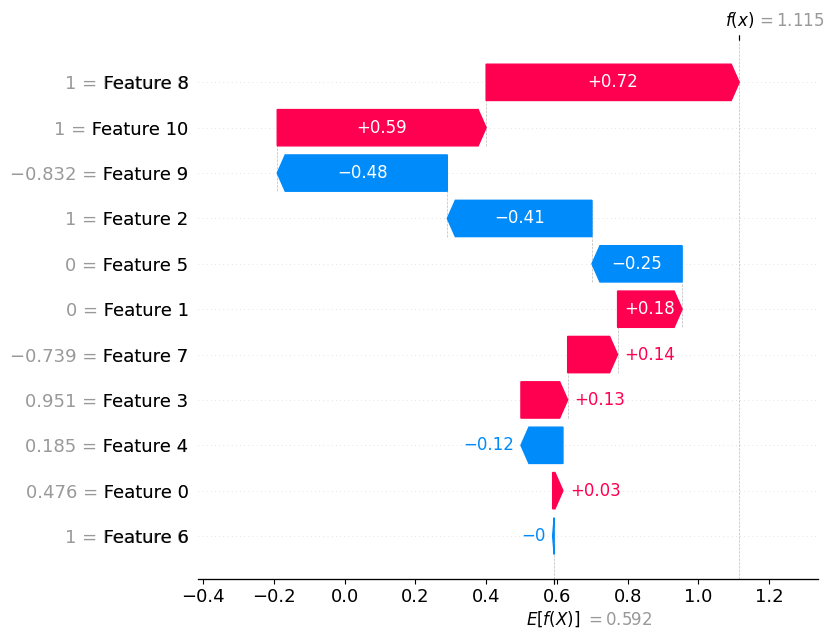

In [53]:
explainer = shap.Explainer(final_model, X_train)
sample = X_test[:1]
shap_values = explainer(sample)
shap.plots.waterfall(shap_values[0], max_display=20)

In this plot we can see the level of contributions of each feature on the final result. In magenta we can see the features that contributed the most. Many started from a negative value, the meaning of which may be that initially its value negatively impacted the final result, but over time it reversed the trend. In blue instead we have the exact opposite, that is, features that impact less in the resolution of the task.

In [54]:
true_label = y_test[0]
predicted_class = final_model.predict(sample)[0]
print(f"Predicted Class: {predicted_class}")
print(f"True Class: {true_label}")

Predicted Class: 1
True Class: 1


### Single sample

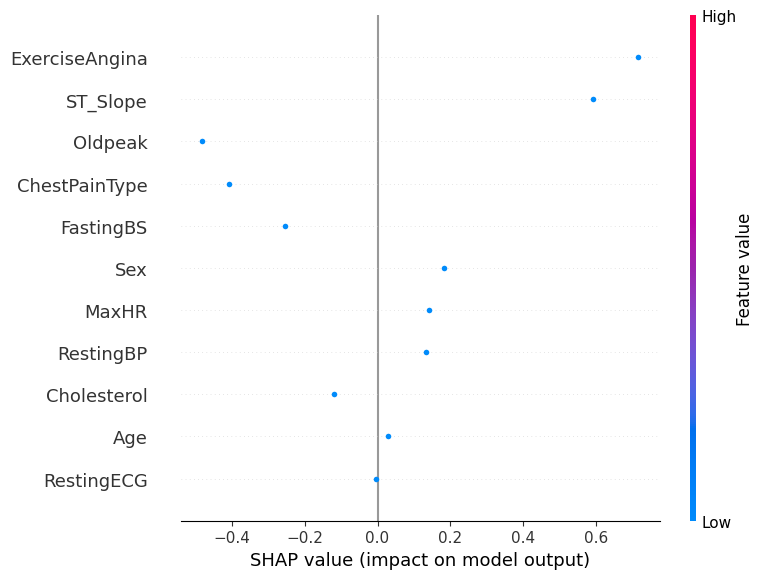

In [55]:
shap.summary_plot(shap_values, features=sample, feature_names=dataset.columns[:-1])

### Test set

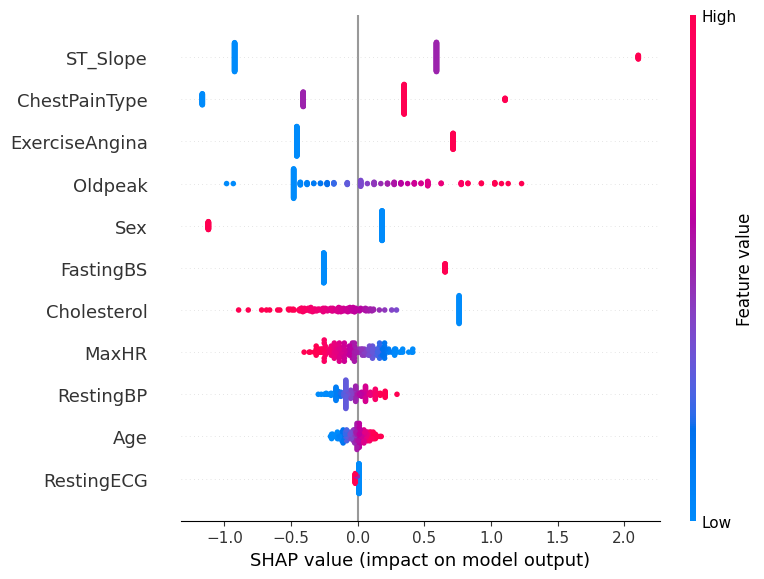

In [56]:
shap_values_full = explainer(X_test)
shap.summary_plot(shap_values_full, features=X_test, feature_names=dataset.columns[:-1])

Here we can see the same through a scatterplot on both the single sample and the whole test set.